Building a Computer Vision Classifier from the kaggle dataset Bone Fracture Multiregion

Lets get out data first

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Bone_Fracture_Kaggle/archive.zip -d /content/drive/MyDrive/Bone_Fracture_Kaggle/data/

In [ ]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} dirs, {len(filenames)} images in '{dirpath}'.")

data_path = "/content/drive/MyDrive/Bone_Fracture_Kaggle/data/"
walk_through_dir(data_path)

1 dirs, 1 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/'.
1 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification'.
3 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'.
2 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'.
0 dirs, 235 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured'.
0 dirs, 256 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured'.
2 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'.
0 dirs, 4596 images in '/content/drive/MyDrive/Bon

Visualising our image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory /content/drive/MyDrive/Bone_Fracture_Kaggle/data/ found.
1 dirs, 1 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/'.
1 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification'.
3 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'.
2 dirs, 0 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'.
0 dirs, 235 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured'.
0 dirs, 256 images in '/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fracture

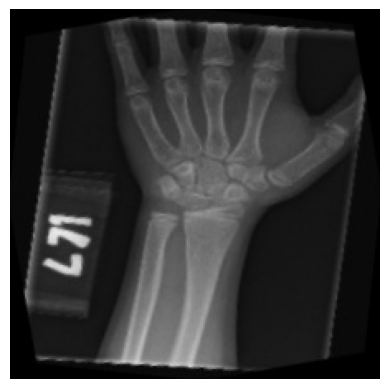

In [ ]:
import os
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt


try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    raise


data_path = "/content/drive/MyDrive/Bone_Fracture_Kaggle/data/"


if not os.path.exists(data_path):
    print(f"Dataset directory {data_path} does not exist. Attempting to unzip...")
    zip_path = "/content/drive/MyDrive/Bone_Fracture_Kaggle/archive.zip"
    if os.path.exists(zip_path):
        try:
            !unzip -q {zip_path} -d {data_path}
            print("Unzipping completed.")
        except Exception as e:
            print(f"Error unzipping dataset: {e}")
            raise
    else:
        print(f"Zip file {zip_path} not found. Please check the path.")
        raise
else:
    print(f"Dataset directory {data_path} found.")


def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} dirs, {len(filenames)} images in '{dirpath}'.")

walk_through_dir(data_path)


import os
import random
from PIL import Image
import matplotlib.pyplot as plt


not_fractured_dir = "/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured"


if os.path.exists(not_fractured_dir):

    image_files = [f for f in os.listdir(not_fractured_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:

        img_file = random.choice(image_files)
        img_path = os.path.join(not_fractured_dir, img_file)

        try:

            print(f"Loading image: {img_path}")
            img = Image.open(img_path)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error loading or displaying image: {e}")
    else:
        print(f"No image files found in {not_fractured_dir}.")
else:
    print(f"Directory {not_fractured_dir} not found. Please verify the path.")

Preprocessing our data and Loading our dataset using DataLoaders

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception as e:
            print(f"Skipping corrupt image: {self.samples[index][0]} - {str(e)}")
            return None  # Corrupt image ko skip karo


base_path = "/content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/"
train_data = SafeImageFolder(base_path + "train", transform=preprocess)
val_data = SafeImageFolder(base_path + "val", transform=preprocess)
test_data = SafeImageFolder(base_path + "test", transform=preprocess)


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"Classes: {train_data.classes}")
print(f"Train samples: {len(train_data)}")

Classes: ['fractured', 'not fractured']
Train samples: 9223


Training Our Model

In [ ]:
import torch.nn as nn
from torchvision import models
import torch # Import the torch module


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale input
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
model = model.to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    print(f"Val Accuracy: {100 * correct / total:.2f}%")


torch.save(model.state_dict(), "bone_fracture_model.pth")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg - image file is truncated (14 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg - image file is truncated (40 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg - image file is truncated (10 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg - image file is truncated (33 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bon

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004134.jpg - image file is truncated (1 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004143.jpg - image file is truncated (10 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004148.jpg - image file is truncated (14 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004149.jpg - image file is truncated (33 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fractur

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        if images is None:
            continue
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg - image file is truncated (1 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004143.jpg - image file is truncated (10 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg - image file is truncated (14 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004149.jpg - image file is truncated (33 bytes not processed)
Skipping corrupt image: /content/drive/MyDrive/Bone_Fracture_Kaggle/data/Bone_Fra

In [ ]:
torch.save(model.state_dict(), "bone_fracture_model.pth")

In [ ]:
from google.colab import files
files.download("/content/bone_fracture_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>